In [64]:
import numpy as np
from scipy.interpolate import interp1d
import qnm_filter
import sys
import qnm
import random
import argparse
import scipy.linalg as sl
from scipy.special import logsumexp
from pathlib import Path
import glob
import matplotlib.pyplot as pl

In [89]:
def signal_creator():
    global signal, signal220, signal200, t_range, mass
    injected = (100, 0.5)
    mass = qnm_filter.Filter.mass_unit(injected[0])
    omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    omega200 = qnm.modes_cache(s=-2,l=2,m=0,n=0)(a=injected[1])[0]

    mmax = 8.4 * 1e-21
    phase1 = np.pi/3
    A220x = mmax*np.cos(phase1)
    A220y = mmax*np.sin(phase1)
    phase2 = np.pi/3
    A200x = mmax*np.cos(phase2)
    A200y = mmax*np.sin(phase2)

    amp220 = 1
    amp200 = 1

    sampling_frequency = 4096 * 1  # in Hz
    duration = 4  # in second
    t_range = np.arange(-duration / 2, duration / 2, 1 / sampling_frequency)
    signal220 = np.real(amp220 * (A220x + 1j * A220y) * np.exp(-1j * omega220 * np.abs(t_range / mass)))
    signal200 = np.real(amp200 * (A200x + 1j * A200y) * np.exp(-1j * omega200 * np.abs(t_range / mass)))
    signal = signal220+signal200

In [90]:
mmax = 8.4 * 1e-21
delta_mass = 2.0
delta_chi = 0.01
massspace = np.arange(30, 160, delta_mass)
chispace = np.arange(0.0, 0.99, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [91]:
signal_creator()
acf_scale = 1e-2

In [131]:
acf_space = np.logspace(-1, 0, 50)
snr_arr = []
nofilter_arr = []
for i in acf_space:
    fit = qnm_filter.Network(segment_length=0.2, srate=4096 * 1, t_init=3*mass)
    fit.original_data['H1'] = qnm_filter.RealData(signal, index=t_range)
    fit.detector_alignment()
    fit.condition_data('original_data', remove_mean=False)
    fit.compute_acfs('original_data')
    temp_acf = np.full(len(fit.acfs['H1']), 0, dtype = np.double)
    temp_acf[0] = (mmax)**2*i
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()

    fit.original_data['H1'] = qnm_filter.RealData(signal220+signal200, index=t_range)
    fit.condition_data('original_data', remove_mean=False)
    template = fit.truncate_data(fit.original_data)['H1']
    SNRtot = fit.compute_SNR(None, template, 'H1', optimal=True)
    
    nofilter = logsumexp(
        np.array(
            [fit.compute_likelihood(apply_filter=False)]
            * len(massspace)
            * len(chispace)
        )
    )
    
    snr_arr.append(SNRtot)
    nofilter_arr.append(nofilter)
    
snr_arr = np.array(snr_arr)
nofilter_arr = np.array(nofilter_arr)

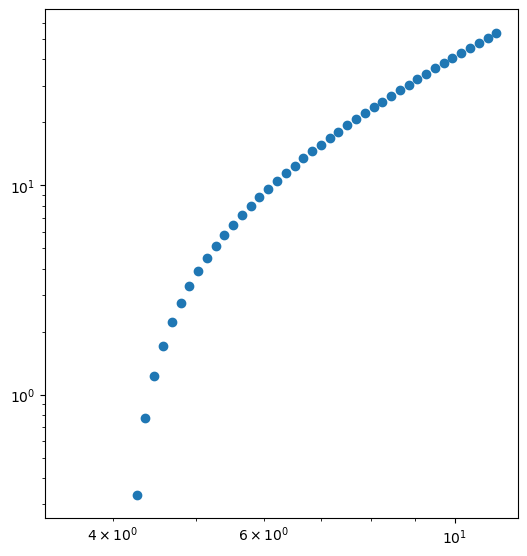

In [132]:
pl.loglog(snr_arr, -nofilter_arr, 'o')

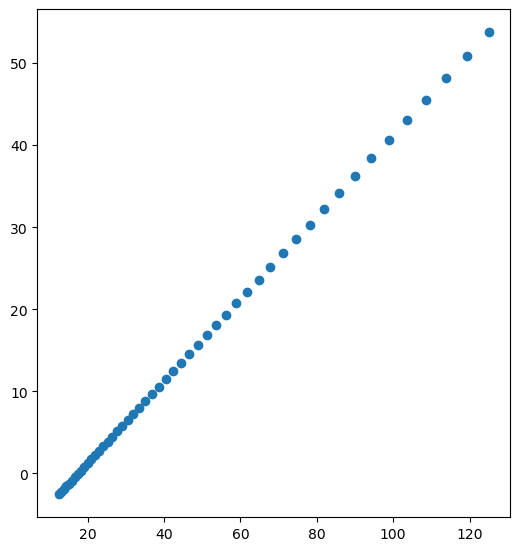

In [137]:
pl.plot(snr_arr**2, -nofilter_arr, 'o')

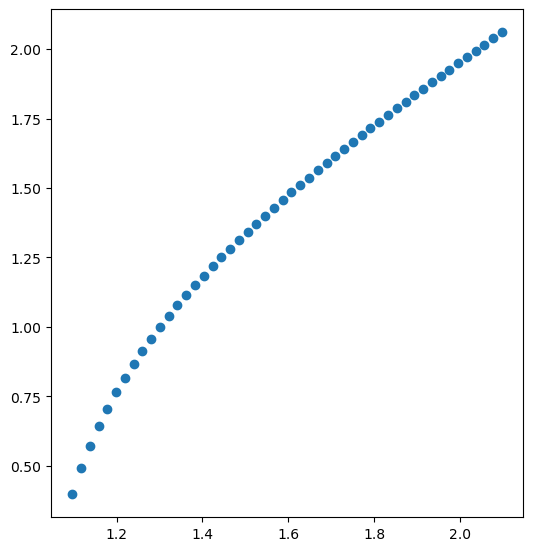

In [144]:
pl.plot(np.log10(snr_arr**2), np.log10(snr_arr**2-10), 'o')

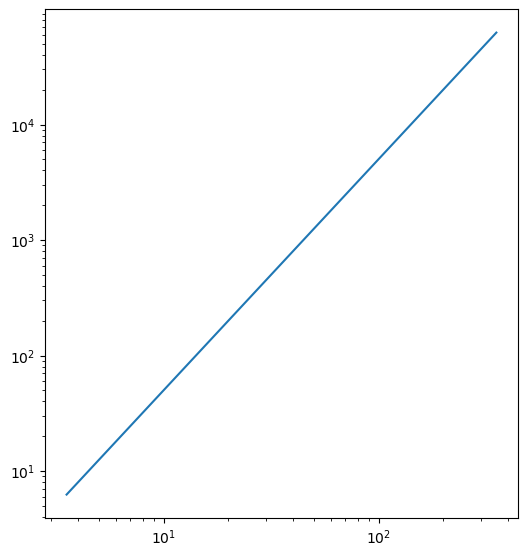

In [130]:
# snr_space = np.linspace(0, 10, 50)
evidence = -0.5*snr_arr**2
pl.loglog(snr_arr, -evidence)

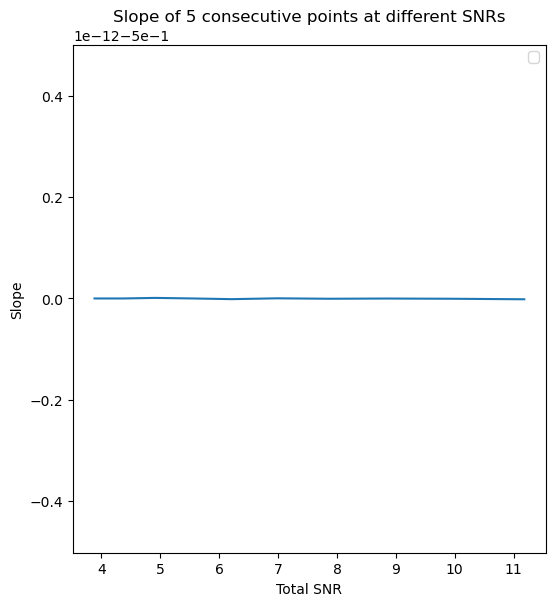

In [134]:
slope_arr = []
for i in range(len(snr_arr)//5):
    slope, _ = np.polyfit((snr_arr**2)[5*i:5*i+5], nofilter_arr[5*i:5*i+5], deg=1, cov=False)
    slope_arr.append(slope)
pl.plot(snr_arr[::5], slope_arr)

pl.title("Slope of 5 consecutive points at different SNRs")
pl.xlabel("Total SNR")
pl.ylabel("Slope")
pl.legend()

In [135]:
slope_arr

[-0.5000000000000019,
 -0.5000000000000009,
 -0.5000000000000004,
 -0.5000000000000009,
 -0.5,
 -0.5000000000000017,
 -0.5000000000000002,
 -0.4999999999999992,
 -0.5000000000000003,
 -0.5000000000000003]

In [99]:
likelihood=0
truncation = fit.truncate_data(fit.original_data)
for ifo, data in truncation.items():
    wd = sl.cho_solve((fit.cholesky_L[ifo], True), data)
    likelihood -= 0.5 * np.dot(data, wd)

In [100]:
template = fit.truncate_data(fit.original_data)['H1']
template_w = sl.cho_solve((fit.cholesky_L[ifo], True), template)
snr_opt = np.sqrt(np.dot(template, template_w))

In [105]:
-0.5*snr_opt**2

-0.6250289518970132

In [106]:
likelihood

-0.6250289518970134

ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

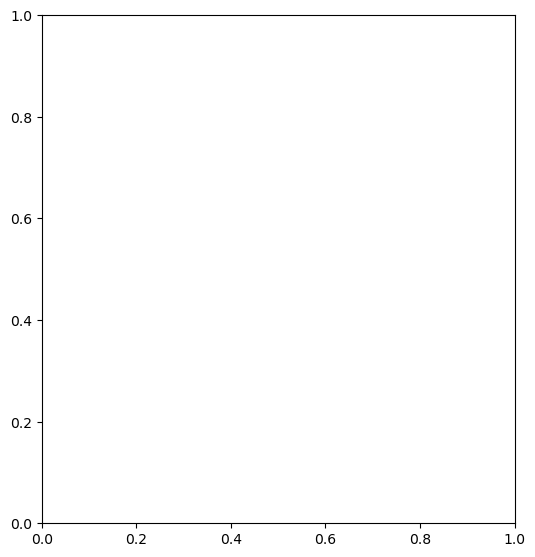

In [58]:
fit = qnm_filter.Network(segment_length=0.2, srate=4096 * 1, t_init=0.0)
fit.original_data['H1'] = qnm_filter.RealData(signal, index=t_range)
fit.detector_alignment()
fit.condition_data('original_data', remove_mean=False)
fit.compute_acfs('original_data')
temp_acf = np.full(len(fit.acfs['H1']), 0, dtype = np.double)
temp_acf[0] = (mmax)**2*acf_scale
fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
fit.cholesky_decomposition()
fit.first_index()

likelihood220, evidence220 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, model_list=[(2,2,0,'p')])
likelihood200, evidence200 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, model_list=[(2,0,0,'p')])
likelihood220_200, evidence220_200 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 8, 
                                              model_list=[(2,2,0,'p'),(2,0,0,'p')])
nofilter = logsumexp(
    np.array(
        [fit.compute_likelihood(apply_filter=False)]
        * len(massspace)
        * len(chispace)
    )
)

fit.original_data['H1'] = qnm_filter.RealData(signal220, index=t_range)
fit.condition_data('original_data', remove_mean=False)
template = fit.truncate_data(fit.original_data)['H1']
SNR220 = fit.compute_SNR(None, template, 'H1', optimal=True)

fit.original_data['H1'] = qnm_filter.RealData(signal200, index=t_range)
fit.condition_data('original_data', remove_mean=False)
template = fit.truncate_data(fit.original_data)['H1']
SNR200 = fit.compute_SNR(None, template, 'H1', optimal=True)

fit.original_data['H1'] = qnm_filter.RealData(signal220+signal200, index=t_range)
fit.condition_data('original_data', remove_mean=False)
template = fit.truncate_data(fit.original_data)['H1']
SNRtot = fit.compute_SNR(None, template, 'H1', optimal=True)

In [59]:
credible_region220_200 = qnm_filter.find_credible_region(likelihood220_200, num_cpu = 9)
credible_region200 = qnm_filter.find_credible_region(likelihood200, num_cpu = 9)
credible_region220 = qnm_filter.find_credible_region(likelihood220, num_cpu = 9)

Text(0, 0.5, '$\\chi_f$')

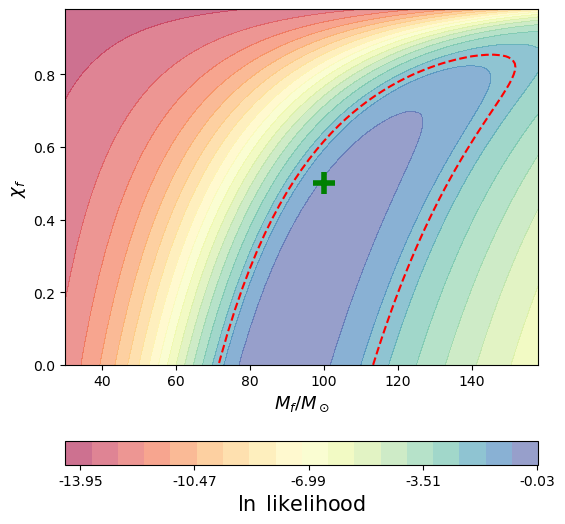

In [62]:
likelihood_data = likelihood220
credible_region = credible_region220

pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=100, y=0.5, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')

In [34]:
SNRtot

4.235566169274395

In [51]:
len(np.arange(30, 240, 0.1))

2100

In [52]:
len(np.arange(30, 240, 0.2))

1050